In [1]:
%run setting.ipynb

In [2]:
import os
import re
import pandas as pd
from pandasql import sqldf
import yfinance as yf

In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.express as px

# configuration

In [4]:
leverage_ratio = 3

ETF = 'NDX'
ETF_3x = 'TQQQ'

# data loading

## QQQ

qqq = yf.Ticker(ETF).history(
    period='max', 
    interval='1d', 
    actions=False)

In [5]:
qqq =  pd.read_csv(f'^NDX.csv', )
qqq = qqq.reset_index()
qqq['id'] = qqq.index
qqq['Date'] = pd.to_datetime(qqq['Date']).dt.date

In [6]:
qqq.to_sql(
name='qqq', 
con = conn,
if_exists='replace', 
index=False,
)

9711

In [7]:
qqq.head(2)

index        Date        Open        High         Low       Close  \
0      0  1985-10-01  110.620003  112.160004  110.565002  112.139999   
1      1  1985-10-02  112.139999  112.540001  110.779999  110.824997   

    Adj Close     Volume  id  
0  112.139999  153160000   0  
1  110.824997  164640000   1

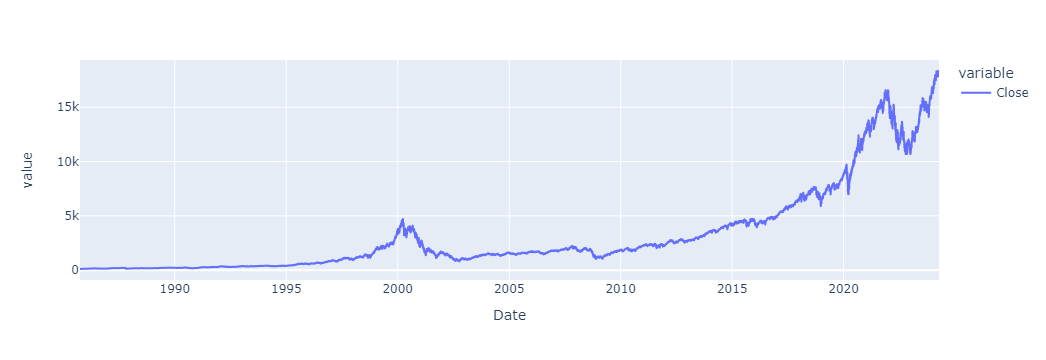

In [8]:
fig = px.line(qqq, x='Date', y=["Close"])
fig.show()

## QLD

data_3x = yf.Ticker(ETF_3x).history(
    period='max', 
    interval='1d', 
    actions=False)

In [9]:
data_3x =  pd.read_csv(f'TQQQ.csv', )
data_3x = data_3x.reset_index()
data_3x['id'] = data_3x.index
data_3x['Date'] = pd.to_datetime(data_3x['Date']).dt.date

In [10]:
data_3x.to_sql(
name='qld', 
con = conn,
if_exists='replace', 
index=False,
)

3566

In [11]:
data_3x.head(2)

index        Date      Open      High       Low     Close  Adj Close  \
0      0  2010-02-11  0.406875  0.434896  0.405573  0.432552   0.420546   
1      1  2010-02-12  0.420781  0.438073  0.418333  0.434323   0.422268   

    Volume  id  
0  3456000   0  
1  8601600   1

# daily percentage

In [12]:
sql_to_table(
u"""
select qqq.*, 
pre_day.Date as pre_Date,
pre_day.Close as pre_Close,
(qqq.Close - pre_day.Close)/pre_day.Close AS Percent    
from qqq 
left join qqq as pre_day on pre_day.id+1 = qqq.id
order by qqq.Date asc
""",
'qqq'
)

9711

In [13]:
sql(u"""
select * 
from qqq
order by Date asc
limit 2
""")

index        Date        Open        High         Low       Close  \
0      0  1985-10-01  110.620003  112.160004  110.565002  112.139999   
1      1  1985-10-02  112.139999  112.540001  110.779999  110.824997   

    Adj Close     Volume  id    pre_Date   pre_Close   Percent  
0  112.139999  153160000   0        None         NaN       NaN  
1  110.824997  164640000   1  1985-10-01  112.139999 -0.011726

# simulation

In [14]:
data_list = sql(f"""
select 
Date,
Percent, 
{leverage_ratio}*Percent as Leveraged_Percent
from qqq
where Percent is not null
""".format(leverage_ratio)).to_dict('records')

In [15]:
data_list[0:3]

[{'Date': '1985-10-02',
  'Percent': -0.011726431351225594,
  'Leveraged_Percent': -0.035179294053676785},
 {'Date': '1985-10-03',
  'Percent': 0.00040609971773787433,
  'Leveraged_Percent': 0.001218299153213623},
 {'Date': '1985-10-04',
  'Percent': -0.007170614038857749,
  'Leveraged_Percent': -0.021511842116573247}]

In [16]:
start_price = qqq['Close'][0]

qqq_price = start_price
tqqq_price = start_price

for r in data_list:
    ###
    qqq_price = qqq_price*(1+r['Percent'])
    r['price'] = qqq_price
    ###
    tqqq_price = tqqq_price*(1+r['Leveraged_Percent'])    
    r['Leveraged_price'] = tqqq_price  

data1 = pd.DataFrame(data_list)

In [17]:
data1.to_sql(
name='leveraged', 
con = conn,
if_exists='replace', 
index=False,
)

9710

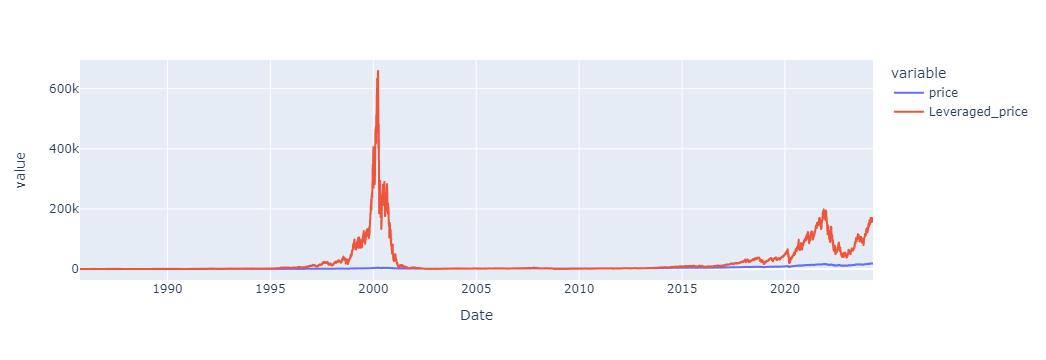

In [18]:
fig = px.line(data1, x='Date', y=[
    'price', 
    'Leveraged_price',
    ])
fig.show()

# regression

In [19]:
compare_3x = sql(u"""
select 
qld.Date,
leveraged.`Leveraged_price`,
qld.Close
from qld
join leveraged on leveraged.Date = qld.Date
order by qld.Date asc
""")

compare_3x.to_sql(
name='compare_3x', 
con = conn,
if_exists='replace', 
index=False,
)

3566

In [20]:
X = compare_3x['Leveraged_price'].to_numpy()
X = np.array([[i] for i in X])
y = compare_3x['Close'].to_numpy()

In [21]:
reg = LinearRegression().fit(X, y)

In [22]:
reg.score(X, y)

print(reg.coef_)

print(reg.intercept_)

[0.00042343]
0.5110819461875611


In [23]:
result = sql(f"""
select 
Date,
`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS simulated_Close,
Close
from compare_3x
""")

result.plot(x ='Date', y=[
    'simulated_Close', 
    'Close',
    ], grid = True)

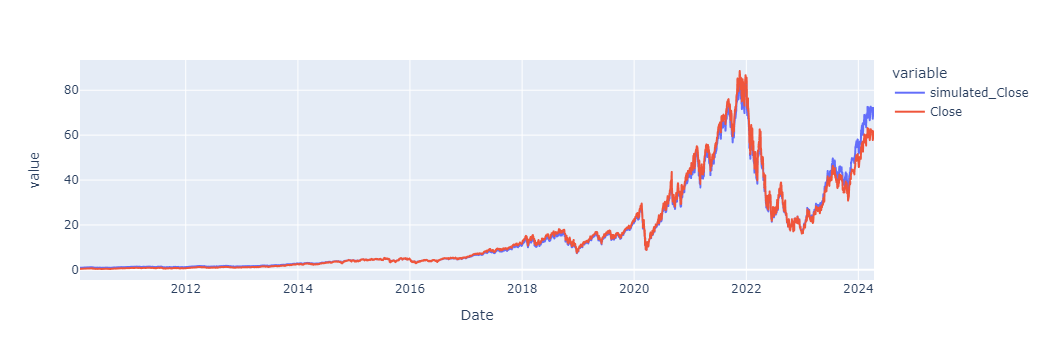

In [24]:
fig = px.line(result, x='Date', y=["simulated_Close",'Close'])
fig.show()

all simulation results

In [25]:
final_result = sql(f"""
select 
data1.Date,
data1.price AS {ETF},
data1.`Leveraged_price` * {reg.coef_[0]} + {reg.intercept_} AS simulated_{ETF_3x},
data_3x.Close as {ETF_3x}
from leveraged as data1
left join qld as data_3x 
on data_3x.Date = data1.Date
""")

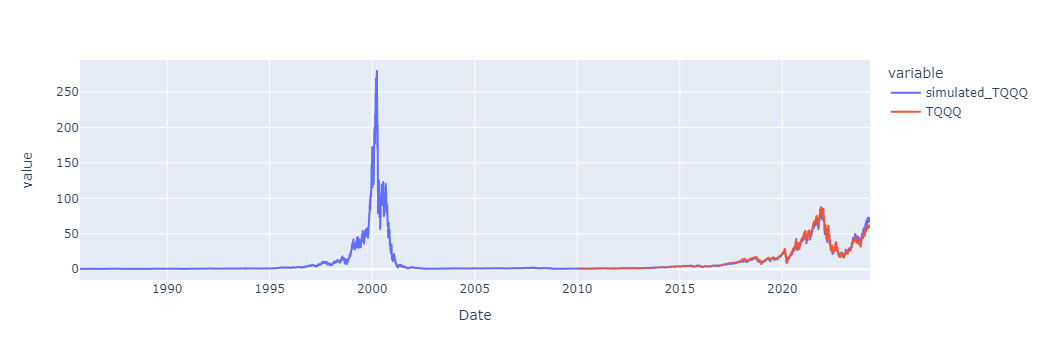

In [26]:
fig = px.line(
final_result, x='Date', y=[
f'simulated_{ETF_3x}',
ETF_3x])
fig.show()

final_result.plot(x ='Date', y=[
    'simulated_{}'.format(ETF_3x),
    ETF_3x,
    ], grid = True)

In [27]:
final_result.to_excel(
f'{ETF_3x}_simulation.xlsx',
index = False,
)

In [28]:
print(f'{ETF_3x}_simulation.xlsx')

TQQQ_simulation.xlsx


# END